# ASX Share Price Analysis

Prototyping for Streamlit app


## 1. Setup notebook

In [37]:
import altair as alt      # charting
import pandas as pd       # 2-d arrays of data
import requests           # making http (web) requests   
import json               # working with JSON formatted data
from pathlib import Path  # working with files/paths nicely
from pandas_cache import pd_cache, timeit

created `./.pd_cache/ dir


In [3]:
from yahooquery import Ticker

# Documentation: https://yahooquery.dpguthrie.com/guide/ticker/historical/

import mplfinance as mpf

# Documentation: https://github.com/matplotlib/mplfinance

## 2. Get and verify data 

We need to establish:
* what data we need to solve the problem
* where we can source the data from
* what (if any) are the terms of use (for each data source)
* have we obtained the data correctly ("reasonableness testing")

### What data do we need?

A list of companies in the [ASX 200](https://en.wikipedia.org/wiki/S%26P/ASX_200) index and their corresponding symbol (code/ticker); this includes their market capitalisation (i.e. how much they are worth) which defines which companies are in the index. While this can and does change through time, changes to the composition of the index are typically slow.

We also what market data and Yahoo Finance seeems to provide this information for free - someone has developed the `yahooquery` package that seems reasonable to use - but we should try and verify this!

#### ASX 200 - Index composition data

This data set provided by the ASX is updated daily (or maybe the day following trading days).

In [4]:
ASX_TICKERS_URL = "https://www.asx.com.au/asx/research/ASXListedCompanies.csv"

We can look at the first $n$ lines of the file using the `curl` and `head` commands in Unix (command line). Remember that the `!` character tells the notebook to execute the command "externally".

_To read about the "Unix command line" often also called the shell - see this [Intro to Bash](https://programminghistorian.org/en/lessons/intro-to-bash)._

In [6]:
!curl -s "$ASX_TICKERS_URL" | head -n 10

ASX listed companies as at Thu Jul 14 21:31:33 AEST 2022

Company name,ASX code,GICS industry group
"MOQ LIMITED","MOQ","Software & Services"
"1414 DEGREES LIMITED","14D","Capital Goods"
"1ST GROUP LIMITED","1ST","Health Care Equipment & Services"
"29METALS LIMITED","29M","Materials"
"333D LIMITED","T3D","Commercial & Professional Services"
"360 CAPITAL ENHANCED INCOME FUND","TCF","Not Applic"
"360 CAPITAL GROUP","TGP","Real Estate"


We can see that this file has a header line i.e. "ASX listed companies as at..." so we need to skip this row. We also observe that the fields provided in this file are: `Company name`, three letter `ASX code` and the [`GICS industry group`](https://www.msci.com/our-solutions/indexes/gics) classification.

In [7]:
asx_tickers_df = pd.read_csv(ASX_TICKERS_URL, skiprows=1)

In [8]:
asx_tickers_df

,Company name,ASX code,GICS industry group
0,MOQ LIMITED,MOQ,Software & Services
1,1414 DEGREES LIMITED,14D,Capital Goods
2,1ST GROUP LIMITED,1ST,Health Care Equipment & Services
3,29METALS LIMITED,29M,Materials
4,333D LIMITED,T3D,Commercial & Professional Services
...,...,...,...
2264,ZINC OF IRELAND NL,ZMI,Materials
2265,ZIP CO LIMITED..,ZIP,Diversified Financials
2266,ZOOM2U TECHNOLOGIES LIMITED,Z2U,Software & Services
2267,ZOONO GROUP LIMITED,ZNO,Materials


Let's also look at the end (`tail`) of the file to see that it looks reasonable (i.e. is not obviously corrupt).

In [9]:
!curl -s "$ASX_TICKERS_URL" | tail -n 10

"ZETA RESOURCES LIMITED","ZER","Not Applic"
"ZEUS RESOURCES LIMITED","ZEU","Energy"
"ZICOM GROUP LIMITED","ZGL","Capital Goods"
"ZIMI LIMITED","ZMM","Technology Hardware & Equipment"
"ZIMPLATS HOLDINGS LIMITED","ZIM","Materials"
"ZINC OF IRELAND NL","ZMI","Materials"
"ZIP CO LIMITED..","ZIP","Diversified Financials"
"ZOOM2U TECHNOLOGIES LIMITED","Z2U","Software & Services"
"ZOONO GROUP LIMITED","ZNO","Materials"
"ZULEIKA GOLD LIMITED","ZAG","Materials"


Utility functions

We try and create (define) functions that will be useful and get re-used throughout the code to make it more readable.

For example, the following function is designed to lookup the full company name from the ASX code.

In [10]:
asx_tickers_df["ASX code"]

0       MOQ
1       14D
2       1ST
3       29M
4       T3D
       ... 
2264    ZMI
2265    ZIP
2266    Z2U
2267    ZNO
2268    ZAG
Name: ASX code, Length: 2269, dtype: object

In [22]:
def lookup_company_name_from_code(asx_code):
  asx_code = asx_code.replace(".AX", "")
  try:
    return asx_tickers_df[asx_tickers_df["ASX code"] == asx_code]["Company name"].to_list()[0].title().replace(".", "")
  except Exception:
    return "Code not found"

In [23]:
company_name = lookup_company_name_from_code("CBA.AX")

In [24]:
company_name

'Commonwealth Bank Of Australia'

In [25]:
lookup_company_name_from_code("IAG")

'Insurance Australia Group Limited'

In [26]:
lookup_company_name_from_code("YYY")

'Code not found'

See also: https://asxportfolio.com/shares-python-for-finance-getting-stock-data

Example ASX API to get latest data -  e.g. CBA: https://www.asx.com.au/asx/1/share/CBA

In [27]:
ASX_DATA_URL = "https://www.asx.com.au/asx/1/share/"

Here is another utility function that we are defining to get/extract the latest market capitalisation information using the [API](https://www.mulesoft.com/resources/api/what-is-an-api) provided by the ASX. We are also returning the date associated with this information. Note that APIs often return information in particular formats. In this case the returned information is formatted as [JSON](https://www.json.org/json-en.html) and we have to parse it appropriately to get the precise details we are after.

In [29]:
def get_market_cap_from_code(asx_code):
  asx_code = asx_code.replace(".AX", "")
  r = requests.get(ASX_DATA_URL + asx_code)
  data = json.loads(r.text)
  try:
    return data["market_cap"], data["last_trade_date"]
  except Exception:
    return None, None

In [31]:
get_market_cap_from_code("IAG")

(10747836898, '2022-07-14T00:00:00+1000')

In [33]:
get_market_cap_from_code("YYY")

(None, None)

In [38]:
@timeit
@pd_cache
def calculate_market_cap(asx_tickers_df):
  asx_tickers_df["market_cap"] = asx_tickers_df["ASX code"].apply(lambda _: get_market_cap_from_code(_)[0])
  return asx_tickers_df

Cache the tickers file with the market capitalisation information as it takes a few minutes to complete - see `pd_cache` decorator. i.e. tmp directory `.pd_cache` directory.

In [43]:
asx_tickers_df = calculate_market_cap(asx_tickers_df)

	 | read .pd_cache/calculate_market_cap_8eca4e.pkl
	 > function calculate_market_cap time: 14.4 ms


In [45]:
asx_200_df = asx_tickers_df.sort_values(by='market_cap', ascending=False).reset_index()[0:200]

In [47]:
asx_200_df;

#### Historical Market data - Yahoo Finance

See `yahooquery` documentation for details - https://yahooquery.dpguthrie.com/

In [48]:
ticker_list = "CBA.AX WBC.AX IAG.AX"

In [49]:
start_date = "2021-01-01"
end_date = "2021-12-31"

In [50]:
tickers = Ticker(ticker_list)

In [51]:
#price_data_df = tickers.history(period='1y', interval='1d')

price_data_df = tickers.history(start=start_date, end=end_date)

In [52]:
price_data_df

open   volume        low       high      close  \
symbol date                                                              
CBA.AX 2021-01-04  82.230003  1414844  82.169998  83.919998  83.750000   
       2021-01-05  83.000000  1809541  82.485001  83.260002  83.230003   
       2021-01-06  82.690002  2252786  82.279999  83.349998  82.900002   
       2021-01-07  84.379997  3011086  83.699997  85.180000  84.580002   
       2021-01-08  84.989998  2446079  84.794998  85.629997  85.629997   
...                      ...      ...        ...        ...        ...   
IAG.AX 2021-12-22   4.230000  3183974   4.190000   4.240000   4.230000   
       2021-12-23   4.240000  2486709   4.210000   4.260000   4.260000   
       2021-12-24   4.290000  1706534   4.270000   4.340000   4.270000   
       2021-12-29   4.320000  3017851   4.310000   4.360000   4.330000   
       2021-12-30   4.350000  2980401   4.300000   4.365000   4.320000   

                    adjclose  dividends  
symbol date                              
CBA.AX 2021-01-04  79.270065        0.0  
       2021-01-05  78.777893        0.0  
       2021-01-06  78.465538        0.0  
       2021-01-07  80.055672        0.0  
       2021-01-08  81.049500        0.0  
...                      ...        ...  
IAG.AX 2021-12-22   4.176455        0.0  
       2021-12-23   4.206076        0.0  
       2021-12-24   4.215950        0.0  
       2021-12-29   4.275190        0.0  
       2021-12-30   4.265316        0.0  

[759 rows x 7 columns]

In [54]:
tickers.key_stats;

In [56]:
tickers.summary_detail;

In [57]:
profile = tickers.asset_profile

In [58]:
profile['CBA.AX']['website']

'https://www.commbank.com.au'

In [59]:
profile['WBC.AX']['website']

'https://www.westpac.com.au'

In [60]:
price_data_df.index.names

FrozenList(['symbol', 'date'])

In [61]:
price_data_df.head(5)

open   volume        low       high      close  \
symbol date                                                              
CBA.AX 2021-01-04  82.230003  1414844  82.169998  83.919998  83.750000   
       2021-01-05  83.000000  1809541  82.485001  83.260002  83.230003   
       2021-01-06  82.690002  2252786  82.279999  83.349998  82.900002   
       2021-01-07  84.379997  3011086  83.699997  85.180000  84.580002   
       2021-01-08  84.989998  2446079  84.794998  85.629997  85.629997   

                    adjclose  dividends  
symbol date                              
CBA.AX 2021-01-04  79.270065        0.0  
       2021-01-05  78.777893        0.0  
       2021-01-06  78.465538        0.0  
       2021-01-07  80.055672        0.0  
       2021-01-08  81.049500        0.0

In [62]:
price_data_df.describe()

,open,volume,low,high,close,adjclose,dividends
count,759.000000,7.590000e+02,759.000000,759.000000,759.000000,759.000000,759.000000
mean,41.724717,5.230122e+06,41.421785,42.022655,41.730909,40.258012,0.006430
std,39.447585,3.578727e+06,39.166958,39.724330,39.465347,38.383175,0.095663
min,4.220000,8.881680e+05,4.190000,4.240000,4.230000,4.176455,0.000000
25%,5.095000,2.763256e+06,5.035000,5.150000,5.080000,4.945079,0.000000
50%,25.030001,4.595204e+06,24.920000,25.190001,25.030001,23.498989,0.000000
75%,87.750000,6.743284e+06,86.830002,88.005001,87.255001,83.913422,0.000000
max,110.000000,4.088116e+07,109.269997,110.190002,110.129997,108.192848,2.000000


In [63]:
price_data_df.reset_index(inplace=True)

In [64]:
price_data_df.dtypes

symbol        object
date          object
open         float64
volume         int64
low          float64
high         float64
close        float64
adjclose     float64
dividends    float64
dtype: object

In [65]:
price_data_df.head()

,symbol,date,open,volume,low,high,close,adjclose,dividends
0,CBA.AX,2021-01-04,82.230003,1414844,82.169998,83.919998,83.750000,79.270065,0.0
1,CBA.AX,2021-01-05,83.000000,1809541,82.485001,83.260002,83.230003,78.777893,0.0
2,CBA.AX,2021-01-06,82.690002,2252786,82.279999,83.349998,82.900002,78.465538,0.0
3,CBA.AX,2021-01-07,84.379997,3011086,83.699997,85.180000,84.580002,80.055672,0.0
4,CBA.AX,2021-01-08,84.989998,2446079,84.794998,85.629997,85.629997,81.049500,0.0


In [66]:
len(price_data_df)

759

In [67]:
price_data_df['date'][0]

datetime.date(2021, 1, 4)

In [68]:
price_data_df["date"] = pd.to_datetime(price_data_df["date"])

## 3. Analysis

What do we need to do / solve?

* Which companies are in the top 200 by market capitalisation?
* Allow user to choose from this list in a sensible manner e.g. lookup and/or predefined favourites list.
* Display the price history and other relevant information for each company selected in an appealing manner (to aide comparison of their relative performance). e.g. may want to look over past year, 6m, 3m, 1m, 1w etc.

In [69]:
chart_ticker = "WBC.AX"

In [70]:
chart_data_df = price_data_df[price_data_df["symbol"] == chart_ticker]

In [71]:
chart_data_df

,symbol,date,open,volume,low,high,close,adjclose,dividends
253,WBC.AX,2021-01-04,19.459999,4044153,19.424999,19.670000,19.629999,18.225410,0.0
254,WBC.AX,2021-01-05,19.469999,4944351,19.379999,19.530001,19.520000,18.123283,0.0
255,WBC.AX,2021-01-06,19.450001,7063517,19.230000,19.500000,19.370001,17.984018,0.0
256,WBC.AX,2021-01-07,19.799999,14348410,19.780001,20.340000,19.990000,18.559652,0.0
257,WBC.AX,2021-01-08,20.110001,7716248,20.020000,20.280001,20.280001,18.828903,0.0
...,...,...,...,...,...,...,...,...,...
501,WBC.AX,2021-12-22,21.129999,4944213,20.930000,21.150000,21.070000,20.544111,0.0
502,WBC.AX,2021-12-23,21.129999,4359824,21.040001,21.180000,21.180000,20.651367,0.0
503,WBC.AX,2021-12-24,21.260000,3039364,21.200001,21.450001,21.200001,20.670868,0.0
504,WBC.AX,2021-12-29,21.450001,9676188,21.400000,21.650000,21.459999,20.924377,0.0


In [72]:
c = alt.Chart(chart_data_df).mark_circle().encode(x='date', y='adjclose')

In [73]:
c

alt.Chart(...)

In [74]:
chart_data_df.set_index('date', inplace=True)

In [75]:
chart_data_df.head()

,symbol,open,volume,low,high,close,adjclose,dividends
date,,,,,,,,
2021-01-04,WBC.AX,19.459999,4044153,19.424999,19.670000,19.629999,18.225410,0.0
2021-01-05,WBC.AX,19.469999,4944351,19.379999,19.530001,19.520000,18.123283,0.0
2021-01-06,WBC.AX,19.450001,7063517,19.230000,19.500000,19.370001,17.984018,0.0
2021-01-07,WBC.AX,19.799999,14348410,19.780001,20.340000,19.990000,18.559652,0.0
2021-01-08,WBC.AX,20.110001,7716248,20.020000,20.280001,20.280001,18.828903,0.0


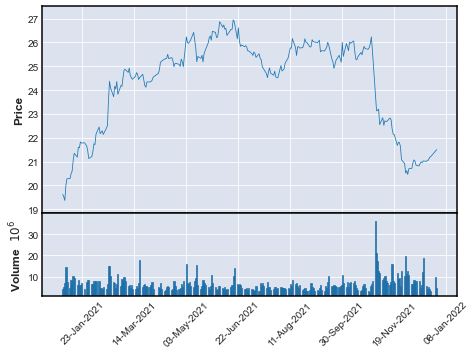

In [76]:
mpf.plot(chart_data_df, type='line', volume=True, show_nontrading=True, datetime_format='%d-%b-%Y')